<a href="https://githubtocolab.com/stavshem/PyCon2021-Topic_Modeling/blob/main/Topic_Modeling.ipynb" target="_parent">
<img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab"/></a>

In [1]:
! pip install --q blingfire spacy transformers sentence-transformers umap-learn hdbscan stop-words

     |████████████████████████████████| 28.3MB 190kB/s 
     |████████████████████████████████| 2.1MB 50.6MB/s 
     |████████████████████████████████| 81kB 12.4MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 6.4MB 25.6MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 3.3MB 47.0MB/s 
     |████████████████████████████████| 901kB 51.9MB/s 
     |████████████████████████████████| 1.2MB 51.0MB/s 
     |████████████████████████████████| 1.2MB 50.8MB/s 


In [2]:
import re
import warnings
import itertools
import collections

import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display

from tqdm.autonotebook import tqdm

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
warnings.ignore()
pd.set_option('display.max_colwidth', 300)
pd.set_option('display.float_format', '{:,.2f}'.format)
tqdm.pandas()

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [4]:
def printmd(string):
    display(Markdown(string))

In [5]:
TAB = '&nbsp;&nbsp;&nbsp;&nbsp;'
BULLET = f'{TAB}➡'

# Topic Discovery

## Prepare Input Text Data

In [6]:
from sklearn.datasets import fetch_20newsgroups
from blingfire import text_to_sentences

from gensim.parsing import strip_tags, strip_numeric, strip_multiple_whitespaces, stem_text, strip_punctuation, remove_stopwords, preprocess_string

In [7]:
data = fetch_20newsgroups(subset='all')['data']

In [8]:
sentence_items = []
for i, document in enumerate(data):
  document_sentences = text_to_sentences(document).split("\n")
  sentence_with_idx = itertools.zip_longest(document_sentences, [i], fillvalue=i)
  sentence_items.extend(sentence_with_idx)

In [9]:
df_sentences = pd.DataFrame(sentence_items, columns=['original_sentence', 'document_id'])

In [10]:
transform_to_lower = lambda s: s.lower()
remove_single_char = lambda s: re.sub(r'\s+\w{1}\s+', '', s)

CLEAN_FILTERS = [strip_tags,
                strip_numeric,
                strip_punctuation, 
                strip_multiple_whitespaces, 
                transform_to_lower,
                remove_stopwords,
                remove_single_char]

def cleaning_pipe(document):
    processed_words = preprocess_string(document, CLEAN_FILTERS)    
    return ' '.join(processed_words)

In [11]:
df_sentences['sentence'] = df_sentences['original_sentence'].progress_apply(cleaning_pipe)

In [12]:
sample_idx = 151
printmd('**Data Cleaning**')
original_sentence, sentence = df_sentences.iloc[sample_idx][['original_sentence', 'sentence']]
print(f'  Raw text: {original_sentence}')
print(f'  Cleaned: {sentence}')

**Data Cleaning**

  Raw text: "Reuss resigned as Outer Head of the Order in 1922 after suffering a stroke and named Crowley his successor.
  Cleaned: reuss resigned outer head order suffering stroke named crowley successor


In [13]:
df_sentences.drop_duplicates(subset='sentence', inplace=True)

MIN_LEN = 50
MAX_LEN = 500
df_sentences['sentence_len'] = df_sentences['sentence'].str.len()
df_sentences = df_sentences[(MIN_LEN <= df_sentences['sentence_len']) & (df_sentences['sentence_len'] <= MAX_LEN)]

In [69]:
df_sentences.reset_index(inplace=True)

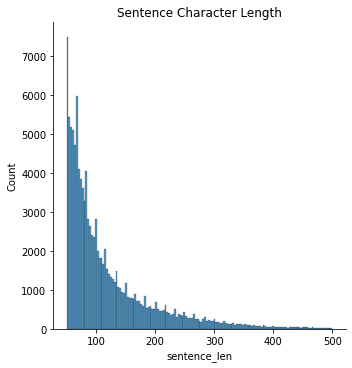

In [41]:
sns.displot(df_sentences['sentence_len'])
plt.title('Sentence Character Length');

In [14]:
df_sentences.head()

,original_sentence,document_id,sentence,sentence_len
0,"From: Mamatha Devineni Ratnam <mr47+@andrew.cmu.edu> Subject: Pens fans reactions Organization: Post Office, Carnegie Mellon, Pittsburgh, PA Lines: 12 NNTP-Posting-Host: po4.andrew.cmu.edu I am sure some bashers of Pens fans are pretty confused about the lack of any kind of posts about the re...",0,mamatha devineni ratnam subject pens fans reactions organization post office carnegie mellon pittsburgh pa lines nntp posting host po andrew cmu edu sure bashers pens fans pretty confused lack kind posts recent pens massacre devils,231
2,"However, I am going to put an end to non-PIttsburghers' relief with a bit of praise for the Pens.",0,going end non pittsburghers relief bit praise pens,50
6,Bowman should let JAgr have a lot of fun in the next couple of games since the Pens are going to beat the pulp out of Jersey anyway.,0,bowman let jagr lot fun couple games pens going beat pulp jersey,64
7,I was very disappointed not to see the Islanders lose the final regular season game.,0,disappointed islanders lose final regular season game,53
9,From: mblawson@midway.ecn.uoknor.edu (Matthew B Lawson) Subject: Which high-performance VLB video card?,1,mblawson midway ecn uoknor edu matthewlawson subject high performance vlb video card,84


In [15]:
printmd(f'**Sentences count**: {df_sentences.shape[0]:,}.')

**Sentences count**: 114,545.

## Step 1 - Sentence Representation

In [16]:
from sentence_transformers import SentenceTransformer

In [17]:
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings_sbert = model.encode(df_sentences['sentence'].values, show_progress_bar=True)

In [20]:
sbert_embeddings_count, sbert_embeddings_size = embeddings_sbert.shape
printmd(f'**Sentence-BERT embeddings**: {sbert_embeddings_count:,} vectors of size {sbert_embeddings_size}.')

**Sentence-BERT embeddings**: 114,545 vectors of size 768.

## Step 2 - Dimensionality Reduction

In [21]:
import umap

In [23]:
embeddings_reduced = umap.UMAP(
    n_neighbors=15, 
    n_components=5, 
    metric='cosine'
).fit_transform(embeddings_sbert)

In [25]:
embeddings_2d = umap.UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(embeddings_sbert)

## Step 3 - Clustering

In [31]:
import hdbscan

In [32]:
cluster = hdbscan.HDBSCAN(
    min_cluster_size=10,
    metric='euclidean',                      
    cluster_selection_method='eom').fit(embeddings_reduced)

In [33]:
df_sentences['cluster_id'] = cluster.labels_

In [34]:
df_sentences_clustered = df_sentences[df_sentences['cluster_id'] != -1]

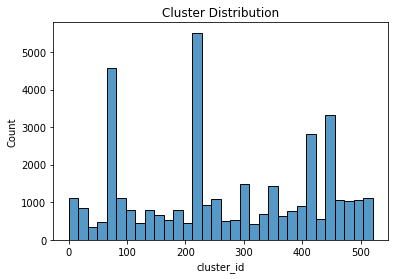

In [35]:
sns.histplot(df_sentences_clustered['cluster_id'], palette='Paired')
plt.title('Cluster Distribution');

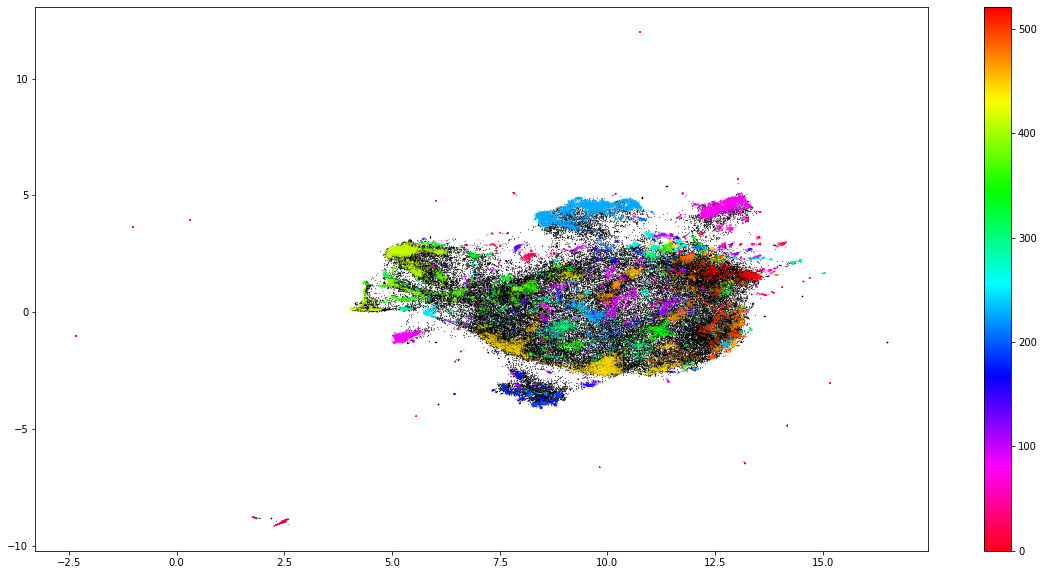

In [43]:
# Prepare data
df_clusters_2d = pd.DataFrame(embeddings_2d, columns=['x', 'y'])
df_clusters_2d['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = df_clusters_2d.loc[df_clusters_2d.labels == -1, :]
clustered = df_clusters_2d.loc[df_clusters_2d.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='black', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar();

In [63]:
df_topics = df_sentences\
  .groupby(['cluster_id'], as_index = False)\
  .agg({'sentence': ' '.join})\
  .rename(columns={'sentence': 'cluster_sentences'})

# Step 4 - Topic Summarization

In [65]:
! curl --silent -O https://raw.githubusercontent.com/UKPLab/sentence-transformers/master/examples/applications/text-summarization/LexRank.py

In [47]:
import spacy

In [48]:
nlp = spacy.load("en_core_web_sm")

In [64]:
df_topics.sample(n=4)

,cluster_id,cluster_sentences
285,284,original post claimed atf fbi pumping napalm building hopes wood stove inside ignite branch davidian members survived inferno claim started armored vehicle punched wall knocked lantern setting table comment cultists close edge hell think reaction hours long assault compound holes punched walls c...
513,512,eugenerosen genie erosen riverside road compuserve sandy hook ct aol gene rosen uznerk mcl ucsb edu andrew krenz subject impala ss going production daveb pogo wv tek com dave butler subject objectivity years jack handey erichlantz ewl world std com timberville va dod yzerman fedorov coffey linds...
280,279,mkagalen lynx dac northeastern edu michael kagalenko subject detect use illegal cipher agk neural hampshire edu andrew kriger subject detect use illegal cipher rboudrie chpc org rob boudrie subject detect use illegal cipher correct illegal send cryptographic code lots things country license ciph...
194,193,cardiologists use ultrasound echocardiography fact considered experts radiologist intensively trained process interpreting diagnostic imaging data aware things physicians arenaware radiologist doctor looking areas radioactive tracer kxgst pitt edu kenneth gilbert subject need radiologist read ul...


In [70]:
from sentence_transformers.util import pytorch_cos_sim
from LexRank import degree_centrality_scores

cluster_id_to_central_sentences = {}
cluster_iter = tqdm(df_sentences.groupby("cluster_id"), desc="Clusters")
for cluster_id, cluster_group in cluster_iter:
    if cluster_id == -1:
      continue
    cluster_emb = np.take(embeddings_sbert, cluster_group.index.values, axis=0)
    cos_scores = pytorch_cos_sim(cluster_emb, cluster_emb).numpy()
    centrality_scores = degree_centrality_scores(cos_scores, threshold=None)
    cluster_examples = cluster_group.iloc[np.argsort(-centrality_scores)[:10]]
    cluster_id_to_central_sentences[cluster_id] = cluster_examples.sentence.values.tolist()

In [75]:
df_topics["central_sentences"] = df_topics["cluster_id"].progress_apply(cluster_id_to_central_sentences.get)

In [77]:
df_topics.sample(n=5)

,cluster_id,cluster_sentences,central_sentences
129,128,survey shows drugs easier fewer eighth graders disapprove number abortions performed dropped dramatically lot abortions weeks think wrong maybe conservative media bias figures homosexuality study released wednesday alan guttmacher institute significantly lower percent figure conventional wisdom ...,"[maybe conservative media bias figures homosexuality study released wednesday alan guttmacher institute significantly lower percent figure conventional wisdom published kinsey report, overall uva drug use actually lower average colleges thomas jefferson sole author virginia statute religious fre..."
449,448,way resources stop applicationabilityiconname properties sorryfeature locals showed reluctance buy units geico started giving away going lose access short send request suspension membership suspend forwarding articles t new trial screwed forgot witnesses witnessescome forth trial come paul brote...,"[gelldav elof iit edu david geller subject parity error halted ideas, project terminated lack timehp engine transferred project, organization clark university lines sent version post ago swallowed void, s impact ross perotfortune eliminating state supported programsmoney, way resources stop appl..."
470,469,organization internet lines expo lcs mit edu xpert tron bwi anybody generatedserver windows nt ccgwt trentu ca grant totten subject ms windows screen grabber paller fedunix org alan paller subject teacher windows nt holland ug cs dal ca shane holland subject comments xtree windows include object...,"[rajiev cfmu eurocontrol rajiev gupta subject windows nt faq, organization internet lines expo lcs mit edu xpert tron bwi anybody generatedserver windows nt, rajiev cfmu eurocontrol rajiev gupta subject questions windows nt, thanks johnskoda windows nt oselectronic learning facilitatorscobol st ..."
135,134,reply sera zuma uucp serdar argic distribution world lines article wiener duke cs duke edu eduard wiener writes culture russia proper ukraine think attempts prove russians descendants finns ukrainians tatars bulgarians bashkirs croats iranians based speculation evidence statement released news s...,"[ar azeri parliamentary committees compiled evidence indicating ar events inspired moscow secure russian imperial rule ar transcaucasus according roman principle divide ar rule, myers think president contacted people russian aid, senior administration official look thinkimportant note united sta..."
260,259,organization case western reserve university cleveland ohio usa lines nntp posting host slc ins cwru edu hello organization case western reserve university cleveland oh usa lines reply cf cleveland freenet edu christopher leigh putnam nntp posting host hela ins cwru edu hot key windows screen sa...,"[organization case western reserve university cleveland oh usa lines reply bq cleveland freenet edu andyberkvam nntp posting host hela ins cwru edu lo writting program checks configuration, organization case western reserve university cleveland oh usa lines reply af cleveland freenet edu chad ci..."


In [78]:
def get_noun_phrases(corpus):
    res = collections.Counter()
    if not corpus:
      return res
    for doc in nlp.pipe(corpus):
      noun_pharses=set()    
      for nc in doc.noun_chunks:
          for np in [nc, doc[nc.root.left_edge.i:nc.root.right_edge.i+1]]:
            noun_pharses.add(np)
            if np[0].tag_ in ("PRP", "WP", "NNP"):
              noun_pharses.add(np)
          res[nc] += 1
      return res

In [ ]:
df_topics["noun_phrases"] = df_topics["central_sentences"].progress_apply(lambda examples: [np for np, _ in get_noun_phrases(examples).most_common(3)])

In [ ]:
df_sentences_per_cluster.sample(n=5)

,cluster_id,cluster_sentences,central_sentences,noun_phrases
494,493,squished fish frankbig fish leslie fish fish dean kaflowitz like away shack catfish ainprettytalk goin fishin goin fishin good friends sure goin fishin especially fishing expeditions targetknowlege looks like duck quacks like duck license fish nets implies fishing village insteadconsidered peopl...,"[especially fishing expeditions targetknowlege, frankbig fish, looked creel fishes, license fish, bring fishing rods possible fish prepared board, fish calpe psc edu, fish tapes rented, fishes, think tank fish tank, nets implies fishing village]","[(especially, fishing, expeditions)]"
413,412,spooks navy required know gist ussid navy way naming particular presidential executive order wouldnmean president nixon private citizen nixon sureslightest president nixon presidentfema president richardnixon president leon fuerth national security advisor vice president europe working implement...,"[stating president decision, decision forward likecertainly president explain justify, ll present president point ll decision, myers working groupmission point convince president, know president announcement, informed president decisions, mean president supports process ve initiated, operation w...","[(president, decision)]"
957,956,xt calls included x person ksh login shell information obtain xfree listed note servers xfree motif source available based xr version posted comp sources x example seen xdm sources use xlib ala xnextevent works xterms havenable compile xdvi way release sco odt use xr xr course works xterm,"[release sco odt use xr xr, motif source available based xr, information obtain xfree listed, version posted comp sources x, use xlib ala xnextevent, works xterms, example seen xdm sources, havenable compile xdvi way, xt calls included, x person ksh login shell]","[(release), (sco, odt), (xr, xr)]"
1034,1033,talk minutes talk ve got couple questions thing talking somebody price talking assume talking opinion orientation specifically talking dsr version talking discuss talk generalizations actually talking rally feel like speak s want talk define inserting conversation come talk spirit talking talk l...,"[says talking, talking, talk, version talking, talked, reminding discuss, talk like, think talking, assume talking, m talking case]",[]
100,99,yes helmet job god given right express opinions carry gun wear helmet goddamn non sequitur guns helmets proper flourish people use face helmet bets s face shield open face aviator sunglasses m interested face shield necessarily helmet piece chin mean carry helmet cams sent helmet letter stating ...,"[challanging open face helmet, good place helmet mirror, decided invest face helmet smart, m interested face shield necessarily helmet piece chin, yes helmet job, helmet, line appears helmets integrity compromised visible signs, gas permeable face helmet face sheild, carry want comply intelligen...","[(open, face, helmet)]"


In [ ]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus, common_dictionary
from gensim import corpora

In [ ]:
topics = [
    ['human', 'computer', 'system', 'interface'],
    ['graph', 'minors', 'trees', 'eps'],
    ['graph', 'minors', 'trees', 'eps'],
    ['woman', 'girl', 'boy']
]

In [ ]:
words = list(itertools.chain.from_iterable(topics))
dct = corpora.Dictionary(topics)

In [ ]:
coherence_model = CoherenceModel(topics=topics,
    corpus=common_corpus,
    dictionary=dct,
    coherence='u_mass'
)
coherence_score = coherence_model.get_coherence_per_topic()
coherence_score

[-9.17107936008472,
 -0.7324081924379064,
 -0.7324081924379064,
 -17.823427587541516]

In [ ]:

coherence_model.get_coherence_per_topic()

[-0.7607246985689725, -13.449306461738571, -13.449306461738571]

In [ ]:

from collections import defaultdict

In [ ]:
documents = [
    "Human machine interface for lab abc computer applications",
    "A survey of user opinion of computer system response time",
    "The EPS user interface management system",
    "System and human system engineering testing of EPS",
    "Relation of user perceived response time to error measurement",
    "The generation of random binary unordered trees",
    "The intersection graph of paths in trees",
    "Graph minors IV Widths of trees and well quasi ordering",
    "Graph minors A survey",
]

# remove common words and tokenize
stoplist = set('for a of the and to in'.split())
texts = [
    [word for word in document.lower().split() if word not in stoplist]
    for document in documents
]

# remove words that appear only once
frequency = defaultdict(int)
for text in texts:
    for token in text:
        frequency[token] += 1

texts = [
    [token for token in text if frequency[token] > 1]
    for text in texts
]

dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# Topic Classification

In [ ]:
from transformers import pipeline

In [ ]:
classifier = pipeline("zero-shot-classification")

In [ ]:
sequence = """\
Israelis will vote again on Tuesday, seeking to end a political \
deadlock that has gripped the country for two years\
"""
candidate_labels = ["elections", "global warming", "covid-19"]

classifiaction_scores = classifier(sequence, candidate_labels)['scores']

In [ ]:
printmd('**Text to Classify:**')
print(sequence)
printmd('**Classification Scores:**')
for label, score in zip(candidate_labels, classifiaction_scores):
  printmd(f'{BULLET} {label} - {score:.2f}')

**Text to Classify:**

Israelis will vote again on Tuesday, seeking to end a political deadlock that has gripped the country for two years


**Classification Scores:**

&nbsp;&nbsp;&nbsp;&nbsp;➡ elections - 0.93

&nbsp;&nbsp;&nbsp;&nbsp;➡ global warming - 0.06

&nbsp;&nbsp;&nbsp;&nbsp;➡ covid-19 - 0.00